In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams

rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
%matplotlib inline


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df



In [2]:
# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b
    
    return block_collection, block_dict

# Example usage:
animals = ['PV_126', 'PV_62']
block_lists = [[6,7, 9,10], [23,24,25,26,27]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals, 
    block_lists=block_lists, 
    experiment_path=experiment_path, 
    bad_blocks=bad_blocks
)

instantiated block number 006 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_006, new OE version
Found the sample rate for block 006 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 006
got it!
instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\exp

In [3]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
#block_numbers = range(40,60)
#block_numbers = [23,24,25,26,27,35,38,39,40,41]
#block_numbers = [7,8,9,10,11,13]
block_numbers = [7]
#bad_blocks = [42, 61, 62, 64, 65, 66] # True for PV_62
bad_blocks = [0]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_126'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b

instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_126\2024_07_18\block_007, new OE version
Found the sample rate for block 007 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 007
got it!


In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 007 has a parsed events file, reading...
Getting eye brightness values for block 007...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [5]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


73it [00:00, 722.39it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


1209it [00:01, 742.22it/s]
1180it [00:01, 760.52it/s]


In [6]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return

for block in block_collection:
    block_get_lizard_movement(block)

# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    label_saccade_movements(block)


path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\recNames=block_007,Animal=PV_126\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


In [7]:
# this code creates the behavior_df for block 007 of animal pv_126 (manually annotated)
# Here, I look for the connection between arena video time and electrophysiological time:
block.final_sync_df['ms_axis'] = block.final_sync_df['Arena_TTL'].values / (block.sample_rate / 1000)
arena_first_frame_ep_time_ms = block.arena_vid_first_t / (block.sample_rate/1000)
arena_last_frame_ep_time_ms = block.arena_vid_last_t / (block.sample_rate/1000)
# PV_126 block_007 ONLY!!!!
raw_times = np.array([0, 132,186,200,240,270,520,795,868,1050])*2
annotations = ['stationary','explores','stationary','explores','stationary','explores','stationary','explores','stationary']
behavior_ep_times = raw_times*1000 + arena_first_frame_ep_time_ms
start_times = behavior_ep_times[:-1]
end_times = behavior_ep_times[1:]
behavior_df = pd.DataFrame.from_dict({
    'start_time':start_times/1000,
    'end_time':end_times/1000,
    'annotation':annotations
})
behavior_df

,start_time,end_time,annotation
0,17.94295,281.94295,stationary
1,281.94295,389.94295,explores
2,389.94295,417.94295,stationary
3,417.94295,497.94295,explores
4,497.94295,557.94295,stationary
5,557.94295,1057.94295,explores
6,1057.94295,1607.94295,stationary
7,1607.94295,1753.94295,explores
8,1753.94295,2117.94295,stationary


ValueError: x and y must have same first dimension, but have shapes (20940,) and (20941,)

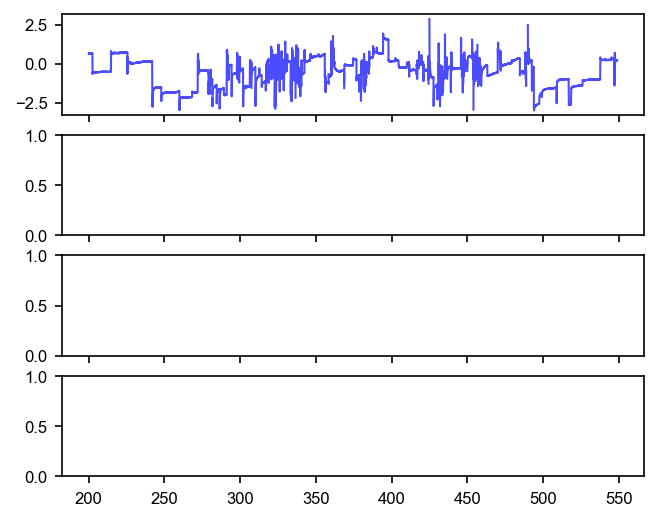

In [9]:
import matplotlib.pyplot as plt
# Reset to default settings
plt.rcdefaults()
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.signal import medfilt
import datetime
import pathlib
from matplotlib.ticker import MultipleLocator
# make pdf compatible
from matplotlib import rc
rc('pdf', fonttype=42)
from matplotlib import rcParams
# Font settings for consistency
rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})


def plot_zoomed_in(start_time, end_time, traces=None, left_df=None, right_df=None, outlier_threshold=3,
                   left_ms=None, right_ms=None, head_movements_ms=None, state_df=None,
                   figure_size=(15, 6), window_size=10000, bin_size=1000, export_path=None):
    """
    Plot zoomed-in eye movement data with options to display state annotations and head movements.
    
    Args:
        start_time (float): Start time in seconds for the zoomed-in region.
        end_time (float): End time in seconds for the zoomed-in region.
        traces (list, optional): List of data traces to plot. Available options: 
                                 ['center_x', 'center_y', 'pupil_diameter', 'saccade_frequency'].
        left_df (pd.DataFrame, required): Left eye data containing columns ['center_x', 'center_y', 'pupil_diameter'].
        right_df (pd.DataFrame, required): Right eye data containing columns ['center_x', 'center_y', 'pupil_diameter'].
        left_ms (array-like, required): Array of left eye saccade onset times in milliseconds.
        right_ms (array-like, required): Array of right eye saccade onset times in milliseconds.
        head_movements_ms (list, optional): List of head movement timestamps in milliseconds.
        state_df (pd.DataFrame, optional): DataFrame containing 'start_time', 'end_time', 'annotation' 
                                           to indicate the animal state (e.g., 'stationary', 'exploration').
        figure_size (tuple, optional): Size of the figure. Defaults to (15, 6).
        window_size (int, optional): Rolling window size for saccade frequency calculation in milliseconds. Defaults to 10000.
        bin_size (int, optional): Bin size for saccade frequency calculation in milliseconds. Defaults to 1000.
    """
    
    # Standardize the data
    left_df_z = left_df.apply(lambda x: zscore(x, nan_policy='omit'))
    right_df_z = right_df.apply(lambda x: zscore(x, nan_policy='omit'))

    # Convert frame numbers to milliseconds and then to seconds
    x_axis = left_df.ms_axis / 1000  # Convert to seconds

    # Filter data within the start and end time
    mask = (x_axis >= start_time) & (x_axis <= end_time)
    zoomed_x_axis = x_axis[mask]

    # Function to remove outliers
    def remove_outliers(trace, threshold=3):
        trace[np.abs(trace) > threshold] = np.nan
        return trace

    # Function to calculate saccade rate
    def calculate_saccade_rate(left_ms, right_ms, window_size=10000, bin_size=1000):
        all_saccades = np.sort(np.unique(np.concatenate((left_ms, right_ms))))
        time_bins = np.arange(start_time * 1000, end_time * 1000 + bin_size, bin_size)
        saccade_count = np.zeros_like(time_bins, dtype=float)
        

        for i in range(len(time_bins)):
            start_time_bin = time_bins[i] - window_size
            end_time_bin = time_bins[i]
            
            saccade_count[i] = np.sum((all_saccades >= start_time_bin) & (all_saccades <= end_time_bin))
        
        # Convert to rate (saccades per second)
        saccade_rate = saccade_count / (window_size / 1000)
        return time_bins, saccade_rate

    # Calculate saccade rate
    time_bins, saccade_rate = calculate_saccade_rate(left_ms, right_ms, window_size, bin_size)

    # Filter time bins and saccade rate within the zoom window
    saccade_mask = (time_bins / 1000 >= start_time) & (time_bins / 1000 <= end_time)
    zoomed_time_bins = time_bins[saccade_mask] / 1000  # Convert from ms to seconds
    zoomed_saccade_rate = saccade_rate[saccade_mask]

    # Initialize plot
    num_traces = len(traces) if traces else 0
    fig, axes = plt.subplots(nrows=num_traces, ncols=1, figsize=figure_size, sharex=True, dpi=150)

    if not isinstance(axes, np.ndarray):
        axes = [axes]  # Ensure axes is always iterable

    for i, trace in enumerate(traces):
        if trace == 'center_x':
            axes[i].plot(zoomed_x_axis, remove_outliers(left_df_z['center_x'][mask], outlier_threshold), 
                         label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, remove_outliers(right_df_z['center_x'][mask], outlier_threshold), 
                         label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('X pos.')
            # Set y-limits and ticks

            # Set the y-limits based on the outlier threshold plus 0.3
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            # Use MultipleLocator to set the major ticks at whole number intervals (e.g., every 1 unit)
            axes[i].yaxis.set_major_locator(MultipleLocator(1))

        elif trace == 'center_y':
            axes[i].plot(zoomed_x_axis, remove_outliers(left_df_z['center_y'][mask], outlier_threshold), 
                         label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, remove_outliers(right_df_z['center_y'][mask], outlier_threshold), 
                         label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Y pos.')
            # Set y-limits and ticks
            # Set the y-limits based on the outlier threshold plus 0.3
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            # Use MultipleLocator to set the major ticks at whole number intervals (e.g., every 1 unit)
            axes[i].yaxis.set_major_locator(MultipleLocator(1))
            axes[i].set_xlim(left=start_time, right=end_time)

        elif trace == 'pupil_diameter':
            axes[i].plot(zoomed_x_axis, remove_outliers(medfilt(left_df_z['pupil_diameter'],121)[mask], outlier_threshold), 
                         label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            axes[i].plot(zoomed_x_axis, remove_outliers(medfilt(right_df_z['pupil_diameter'],121)[mask], outlier_threshold), 
                         label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Pupil Size')
            # Set y-limits and ticks
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            axes[i].set_yticks([-outlier_threshold - 0.3, 0, outlier_threshold + 0.3])

            # Set the y-limits based on the outlier threshold plus 0.3
            axes[i].set_ylim(-outlier_threshold - 0.3, outlier_threshold + 0.3)
            # Use MultipleLocator to set the major ticks at whole number intervals (e.g., every 1 unit)
            axes[i].yaxis.set_major_locator(MultipleLocator(1))
            axes[i].set_xlim(left=start_time, right=end_time)
        elif trace == 'saccade_frequency':
            # For saccade frequency, we keep custom styling
            axes[i].plot(zoomed_time_bins, zoomed_saccade_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccade Rate (Hz)')
        
            # Ensure the x and y ranges start from zero
            # axes[i].set_ylim(bottom=0)
            # if start_time == 0:
            #     axes[i].set_xlim(left=0)
            # 
            # # Move the spines to the origin
            # axes[i].spines['left'].set_position('zero')
            # axes[i].spines['bottom'].set_position('zero')
        
            # Hide the top and right spines
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['right'].set_visible(False)
        
            # Adjust ticks to show them on the bottom and left only
            axes[i].xaxis.set_ticks_position('bottom')
            axes[i].yaxis.set_ticks_position('left')
            # axes[i].axhline(y=start_time, color='black', linewidth=1)
            # axes[i].axvline(x=start_time, color='black', linewidth=1)
            axes[i].set_xlim(left=start_time, right=end_time)
        
        # Add a common xlabel for the last axis
        if i == num_traces - 1:
            axes[i].set_xlabel('Time (seconds)')
            axes[i].tick_params(axis='x', which='major', length=5, color='black')
    
    # Add vertical lines for head movements if provided
    if head_movements_ms is not None:
        for ts in head_movements_ms:
            if start_time <= ts / 1000 <= end_time:
                axes[0].axvline(x=ts / 1000, color='red', linestyle='--', linewidth=1)

    # Plot animal state annotations if provided
    if state_df is not None:
        for _, row in state_df.iterrows():
            if row['end_time'] >= start_time and row['start_time'] <= end_time:
                # Clip times to the zoom window
                state_start = max(row['start_time'], start_time)
                state_end = min(row['end_time'], end_time)

                # Plot a red line above for 'stationary'
                if row['annotation'] == 'stationary':
                    axes[0].hlines(y=outlier_threshold, xmin=state_start, xmax=state_end, color='red', linewidth=3)
                
                # Plot a green line below for 'exploration'
                elif row['annotation'] == 'explores':
                    axes[0].hlines(y=outlier_threshold, xmin=state_start, xmax=state_end, color='green', linewidth=3)

    
    # Minimalistic adjustments
    for ax in axes:
        ax.grid(False)  # Disable the background grid
        ax.spines['top'].set_visible(False)  # Remove the top spine
        ax.spines['right'].set_visible(False)  # Remove the right spine
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='y', which='both', length=5, color='black')  
        ax.tick_params(axis='x', which='both', length=5)
        ax.ticklabel_format(axis='y', style='plain')  # Disable scientific notation
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
    # Add a legend for the traces
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.75, 0.23))

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust to make room for legend
    
    if export_path is not None:
        print(f'exporting to {export_path}')
        plt.savefig(export_path, format='pdf')
    plt.show()


# Example usage with selected traces and state annotations
#export_path=block.analysis_path / 'eye_movement_z_scored_trace.pdf'
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
#export_path= fr'{str(pathlib.Path.cwd())}\figures_export\{t}_locomotion_eye_movement_z_scored_trace.pdf'
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\{t}_locomotion_eye_movement_z_scored_trace.pdf'
plot_zoomed_in(start_time=200, end_time=549, 
               traces=['center_x', 'center_y','pupil_diameter','saccade_frequency'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               outlier_threshold=3,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=None,
               figure_size=(5, 4),export_path=None)

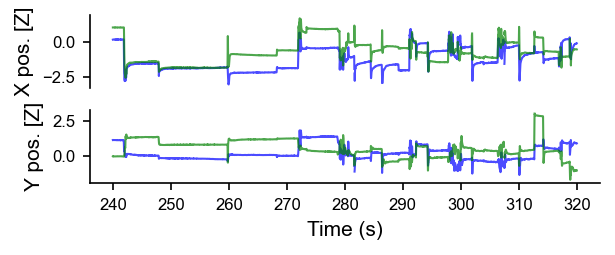

In [285]:
def plot_zoomed_in(start_time, end_time, traces=None, left_df=None, right_df=None, outlier_threshold=3,
                   left_ms=None, right_ms=None, head_movements_ms=None, state_df=None,
                   figure_size=(15, 6), window_size=10000, bin_size=1000, export_path=None):
    """
    Updated function:
    1. Only the final trace shows the x-axis with tick markers and labels.
    2. A single legend is drawn for all traces.
    """
    left_df = left_df.reset_index(drop=True)
    right_df = right_df.reset_index(drop=True)

    x_axis = left_df['ms_axis'] / 1000  # Convert ms to seconds

    left_df_z = left_df.apply(lambda x: zscore(x, nan_policy='omit'))
    right_df_z = right_df.apply(lambda x: zscore(x, nan_policy='omit'))

    mask = (x_axis >= start_time) & (x_axis <= end_time)

    def remove_outliers_aligned(trace, threshold):
        trace = np.asarray(trace)
        outlier_mask = np.abs(trace) <= threshold
        return np.where(outlier_mask, trace, np.nan)

    zoomed_x_axis = x_axis[mask]

    # Prepare data for each trace
    left_center_x = remove_outliers_aligned(left_df_z['center_x'], outlier_threshold)[mask]
    right_center_x = remove_outliers_aligned(right_df_z['center_x'], outlier_threshold)[mask]
    left_center_y = remove_outliers_aligned(left_df_z['center_y'], outlier_threshold)[mask]
    right_center_y = remove_outliers_aligned(right_df_z['center_y'], outlier_threshold)[mask]
    left_pupil_diameter = remove_outliers_aligned(left_df_z['pupil_diameter'], outlier_threshold)[mask]
    right_pupil_diameter = remove_outliers_aligned(right_df_z['pupil_diameter'], outlier_threshold)[mask]

    # Calculate saccade frequency
    def calculate_saccade_rate(left_ms, right_ms, window_size=10000, bin_size=1000):
        all_saccades = np.sort(np.unique(np.concatenate((left_ms, right_ms))))
        time_bins = np.arange(start_time * 1000, end_time * 1000 + bin_size, bin_size)
        saccade_count = np.zeros_like(time_bins, dtype=float)
        for i in range(len(time_bins)):
            start_time_bin = time_bins[i] - window_size
            end_time_bin = time_bins[i]
            saccade_count[i] = np.sum((all_saccades >= start_time_bin) & (all_saccades <= end_time_bin))
        saccade_rate = saccade_count / (window_size / 1000)
        return time_bins, saccade_rate

    time_bins, saccade_rate = calculate_saccade_rate(left_ms, right_ms, window_size, bin_size)
    saccade_mask = (time_bins / 1000 >= start_time) & (time_bins / 1000 <= end_time)
    zoomed_time_bins = time_bins[saccade_mask] / 1000
    zoomed_saccade_rate = saccade_rate[saccade_mask]

    # Create plot
    fig, axes = plt.subplots(nrows=len(traces), ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    # Collect handles and labels for a single legend
    legend_handles = []
    legend_labels = []

    # Iterate over traces and plot
    for i, trace in enumerate(traces):
        if trace == 'center_x':
            line_left, = axes[i].plot(zoomed_x_axis, left_center_x, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            line_right, = axes[i].plot(zoomed_x_axis, right_center_x, label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('X pos. [Z]')
        elif trace == 'center_y':
            line_left, = axes[i].plot(zoomed_x_axis, left_center_y, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            line_right, = axes[i].plot(zoomed_x_axis, right_center_y, label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Y pos. [Z]')
        elif trace == 'pupil_diameter':
            line_left, = axes[i].plot(zoomed_x_axis, left_pupil_diameter, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            line_right, = axes[i].plot(zoomed_x_axis, right_pupil_diameter, label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Diameter')
        elif trace == 'saccade_frequency':
            line_rate, = axes[i].plot(zoomed_time_bins, zoomed_saccade_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccades/Sec.')
            #legend_handles.append(line_rate)
            #legend_labels.append('Saccade Rate')

        # # Add handles and labels for single legend (only once)
        # if i == 0:
        #     legend_handles.append(line_left)
        #     legend_handles.append(line_right)
        #     legend_labels.append('Left Eye')
        #     legend_labels.append('Right Eye')

        # Hide x-axis completely for all but the last trace
        if i < len(traces) - 1:
            axes[i].spines['bottom'].set_visible(False)
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Final adjustments for each trace
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

    # Shared X-axis label on the last trace
    axes[-1].set_xlabel('Time (s)')

    # Add a single legend
    # fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(0.9, 0.9))

    plt.tight_layout()
    if export_path:
        plt.savefig(export_path, format='pdf')
    plt.show()




# Example usage with selected traces and state annotations
#export_path=block.analysis_path / 'eye_movement_z_scored_trace.pdf'
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
#export_path= fr'{str(pathlib.Path.cwd())}\figures_export\{t}_locomotion_eye_movement_z_scored_trace.pdf'
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\{t}_locomotion_eye_movement_z_scored_trace.pdf'
plot_zoomed_in(start_time=240, end_time=320, 
               traces=['center_x', 'center_y'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               outlier_threshold=3,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=None,
               figure_size=(4.2, 1.8),export_path=None)


In [15]:
block.left_eye_data.head()

,OE_timestamp,eye_frame,ms_axis,center_x,center_y,phi,width,height,major_ax,minor_ax,ratio,pupil_diameter_pixels,pupil_diameter,speed_x,speed_y,speed_r
0,914335.0,6.0,45716.75,370.873042,202.720254,0.675232,43.637917,31.559411,43.637917,31.559411,1.382723,274.185122,12.536319,NaN,NaN,NaN
1,914668.0,6.0,45733.40,370.873042,202.720254,0.675232,43.637917,31.559411,43.637917,31.559411,1.382723,274.185122,12.536319,0.000000,0.000000,0.000000
2,915001.0,8.0,45750.05,370.864515,202.794321,1.032815,43.589866,31.439337,43.589866,31.439337,1.386475,273.883208,12.522515,-0.008528,0.074067,0.074556
3,915335.0,9.0,45766.75,370.651201,202.689701,0.923245,43.607223,31.346047,43.607223,31.346047,1.391155,273.992265,12.527502,-0.213314,-0.104620,0.237588
4,915668.0,10.0,45783.40,370.619133,202.727893,1.232060,43.477331,31.419276,43.477331,31.419276,1.383779,273.176126,12.490186,-0.032068,0.038191,0.049869


Main plot exported to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\20250210-1531_single_saccade_245_249_main.pdf
Colorbar exported to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\20250210-1531_single_saccade_245_249_colorbar.pdf


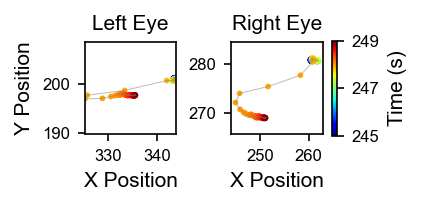

In [153]:
# here is where I make saccade example zoom-ins: 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
def plot_pupil_center_mapping(start_time, end_time, left_df, right_df, figure_size=(12, 6), export_path=None):
    """
    Plots 2D mappings of the pupil centers for the left and right eyes with a separate colorbar.

    Args:
        start_time (float): Start time in seconds for the plot.
        end_time (float): End time in seconds for the plot.
        left_df (pd.DataFrame): DataFrame with columns ['ms_axis', 'center_x', 'center_y'] for the left eye.
        right_df (pd.DataFrame): DataFrame with columns ['ms_axis', 'center_x', 'center_y'] for the right eye.
        figure_size (tuple): Tuple specifying the overall figure size (width, height). Default is (12, 6).
        export_path (str or None): File path to export the plot. If None, the plot will not be saved.
    """
    # Filter data by time
    mask_left = (left_df['ms_axis'] / 1000 >= start_time) & (left_df['ms_axis'] / 1000 <= end_time)
    mask_right = (right_df['ms_axis'] / 1000 >= start_time) & (right_df['ms_axis'] / 1000 <= end_time)
    
    # Extract relevant data
    times_left = left_df['ms_axis'][mask_left] / 1000  # Convert ms to seconds
    times_right = right_df['ms_axis'][mask_right] / 1000  # Convert ms to seconds
    center_x_left = left_df['center_x'][mask_left]
    center_y_left = left_df['center_y'][mask_left]
    center_x_right = right_df['center_x'][mask_right]
    center_y_right = right_df['center_y'][mask_right]
    
    # Normalize times for color mapping
    norm = Normalize(vmin=start_time, vmax=end_time)
    cmap = plt.cm.jet
    
    # Calculate differential range
    range_x_left = center_x_left.max() - center_x_left.min()
    range_x_right = center_x_right.max() - center_x_right.min()
    range_y_left = center_y_left.max() - center_y_left.min()
    range_y_right = center_y_right.max() - center_y_right.min()

    # Use the largest range between x and y for consistent square plots
    max_range = max(range_x_left, range_x_right, range_y_left, range_y_right)

    # Center the ranges around the midpoints
    center_x_left_mid = (center_x_left.max() + center_x_left.min()) / 2
    center_y_left_mid = (center_y_left.max() + center_y_left.min()) / 2
    center_x_right_mid = (center_x_right.max() + center_x_right.min()) / 2
    center_y_right_mid = (center_y_right.max() + center_y_right.min()) / 2

    # Set square limits for both plots
    x_lim_left = (center_x_left_mid - max_range / 2, center_x_left_mid + max_range / 2)
    y_lim_left = (center_y_left_mid - max_range / 2, center_y_left_mid + max_range / 2)
    x_lim_right = (center_x_right_mid - max_range / 2, center_x_right_mid + max_range / 2)
    y_lim_right = (center_y_right_mid - max_range / 2, center_y_right_mid + max_range / 2)
    
    # Create figure for the main plots
    fig, axes = plt.subplots(1, 2, figsize=figure_size, dpi=150, constrained_layout=True)
    scatter_left = axes[0].scatter(center_x_left, center_y_left, c=times_left, cmap=cmap, norm=norm, s=3)
    scatter_right = axes[1].scatter(center_x_right, center_y_right, c=times_right, cmap=cmap, norm=norm, s=3)
    
    # Add connecting lines for trajectory
    axes[0].plot(center_x_left, center_y_left, color='gray', alpha=0.5, linewidth=0.5)
    axes[1].plot(center_x_right, center_y_right, color='gray', alpha=0.5, linewidth=0.5)
    
    # Set titles, labels, and square limits
    axes[0].set_title('Left Eye', fontsize=10)
    axes[1].set_title('Right Eye', fontsize=10)
    axes[0].set_xlim(x_lim_left)
    axes[0].set_ylim(y_lim_left)
    axes[1].set_xlim(x_lim_right)
    axes[1].set_ylim(y_lim_right)
    for i, ax in enumerate(axes):
        if i ==0:
            ax.set_ylabel('Y Position', fontsize=10)
        ax.set_xlabel('X Position', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')  # Maintain 1:1 mapping

    # Add colorbar directly to the main figure
    tick_position = np.linspace(start_time, end_time, num=3)
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical', fraction=0.02, pad=0.04,ticks=tick_position)
    cbar.set_label('Time (s)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Export both plots if a path is provided
    if export_path is not None:
        main_plot_path = export_path.replace('.pdf', '_main.pdf')
        colorbar_path = export_path.replace('.pdf', '_colorbar.pdf')
        fig.savefig(main_plot_path, format='pdf')
        #cbar_fig.savefig(colorbar_path, format='pdf')
        print(f"Main plot exported to {main_plot_path}")
        print(f"Colorbar exported to {colorbar_path}")

    plt.show()

t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
s_t = 245
e_t = 249
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\{t}_single_saccade_{s_t}_{e_t}.pdf'
plot_pupil_center_mapping(
    start_time=s_t,
    end_time=e_t,
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    figure_size=(2.7,1.7),
    export_path=export_path)

Main plot exported to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\20250210-1420_single_saccade_305_310_main.pdf


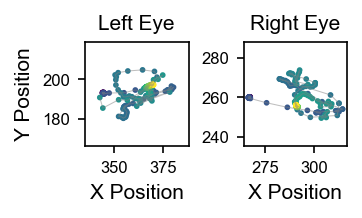

Colorbar exported to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\20250210-1420_single_saccade_305_310_colorbar.pdf


In [137]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_pupil_center_mapping(start_time, end_time, left_df, right_df, figure_size=(12, 6), export_path=None):
    """
    Plots 2D mappings of the pupil centers for the left and right eyes with a separate colorbar.
    The span of the XY axis is determined dynamically by the data range, while ensuring a fixed figure size.

    Args:
        start_time (float): Start time in seconds for the plot.
        end_time (float): End time in seconds for the plot.
        left_df (pd.DataFrame): DataFrame with columns ['ms_axis', 'center_x', 'center_y'] for the left eye.
        right_df (pd.DataFrame): DataFrame with columns ['ms_axis', 'center_x', 'center_y'] for the right eye.
        figure_size (tuple): Tuple specifying the overall figure size (width, height). Default is (12, 6).
        export_path (str or None): File path to export the plot. If None, the plot will not be saved.
    """
    # Filter data by time
    mask_left = (left_df['ms_axis'] / 1000 >= start_time) & (left_df['ms_axis'] / 1000 <= end_time)
    mask_right = (right_df['ms_axis'] / 1000 >= start_time) & (right_df['ms_axis'] / 1000 <= end_time)

    # Extract relevant data
    times_left = left_df['ms_axis'][mask_left] / 1000
    times_right = right_df['ms_axis'][mask_right] / 1000
    center_x_left = left_df['center_x'][mask_left]
    center_y_left = left_df['center_y'][mask_left]
    center_x_right = right_df['center_x'][mask_right]
    center_y_right = right_df['center_y'][mask_right]

    # Normalize times for color mapping
    norm = Normalize(vmin=start_time, vmax=end_time)
    cmap = plt.cm.viridis

    # Determine natural XY span from data
    range_x_left = center_x_left.max() - center_x_left.min()
    range_y_left = center_y_left.max() - center_y_left.min()
    range_x_right = center_x_right.max() - center_x_right.min()
    range_y_right = center_y_right.max() - center_y_right.min()

    # Use the largest range between x and y for consistent square plots
    max_range = max(range_x_left, range_x_right, range_y_left, range_y_right) + 5

    # Center the ranges around the midpoints
    center_x_left_mid = (center_x_left.max() + center_x_left.min()) / 2
    center_y_left_mid = (center_y_left.max() + center_y_left.min()) / 2
    center_x_right_mid = (center_x_right.max() + center_x_right.min()) / 2
    center_y_right_mid = (center_y_right.max() + center_y_right.min()) / 2

    # Set identical XY limits for both plots based on computed max_range
    half_span = max_range / 2
    x_lim_left = (center_x_left_mid - half_span, center_x_left_mid + half_span)
    y_lim_left = (center_y_left_mid - half_span, center_y_left_mid + half_span)
    x_lim_right = (center_x_right_mid - half_span, center_x_right_mid + half_span)
    y_lim_right = (center_y_right_mid - half_span, center_y_right_mid + half_span)

    # Create figure for the main plots
    fig, axes = plt.subplots(1, 2, figsize=figure_size, dpi=150, constrained_layout=True)
    scatter_left = axes[0].scatter(center_x_left, center_y_left, c=times_left, cmap=cmap, norm=norm, s=3)
    scatter_right = axes[1].scatter(center_x_right, center_y_right, c=times_right, cmap=cmap, norm=norm, s=3)

    # Add connecting lines for trajectory
    axes[0].plot(center_x_left, center_y_left, color='gray', alpha=0.5, linewidth=0.5)
    axes[1].plot(center_x_right, center_y_right, color='gray', alpha=0.5, linewidth=0.5)

    # Set titles, labels, and limits
    axes[0].set_title('Left Eye', fontsize=10)
    axes[1].set_title('Right Eye', fontsize=10)
    axes[0].set_xlim(x_lim_left)
    axes[0].set_ylim(y_lim_left)
    axes[1].set_xlim(x_lim_right)
    axes[1].set_ylim(y_lim_right)

    # Ensure identical axis proportions
    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_ylabel('Y Position', fontsize=10)
        ax.set_xlabel('X Position', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')  # Maintain 1:1 mapping

    # Export the main plot if needed
    if export_path is not None:
        main_plot_path = export_path.replace('.pdf', '_main.pdf')
        fig.savefig(main_plot_path, format='pdf')
        print(f"Main plot exported to {main_plot_path}")

    plt.show()

    # -------- CREATE SEPARATE COLORBAR --------
    cbar_fig, cbar_ax = plt.subplots(figsize=(0.2, figure_size[1]), dpi=150)  # Match height to main figure
    tick_position = np.linspace(start_time, end_time, num=3)
    
    # Ensure ScalarMappable is correctly set up
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  
    
    # Create colorbar and force labels/ticks to render
    cbar = cbar_fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=tick_position)
    cbar.set_label('Time (s)', fontsize=10)  # Explicitly add label
    cbar.ax.set_yticklabels([f"{t:.1f}" for t in tick_position])  # Force tick labels as formatted text
    cbar.ax.tick_params(labelsize=8, which='both')  # Ensure both major and minor ticks render
    
    # Export the standalone colorbar figure
    if export_path is not None:
        colorbar_path = export_path.replace('.pdf', '_colorbar.pdf')
        cbar_fig.savefig(colorbar_path, format='pdf', bbox_inches='tight')  # Prevent cropping issues
        print(f"Colorbar exported to {colorbar_path}")


    plt.close(cbar_fig)  # Close colorbar figure to prevent display issues
    
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
s_t = 305
e_t = 310
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\{t}_single_saccade_{s_t}_{e_t}.pdf'
plot_pupil_center_mapping(
    start_time=s_t,
    end_time=e_t,
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    figure_size=(2.3,1.3),
    export_path=export_path)

Main plot exported to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\20250211-1649_single_saccade_284.4_284.6_main.pdf


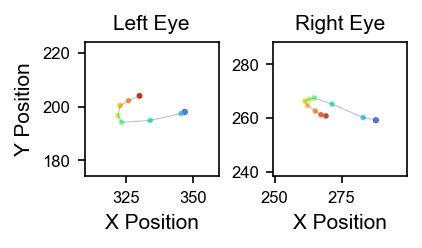

Colorbar exported to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\20250211-1649_single_saccade_284.4_284.6_colorbar.pdf


In [262]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_pupil_center_mapping(start_time, end_time, left_df, right_df, figure_size=(12, 6), export_path=None, xy_span=50):
    """
    Plots 2D mappings of the pupil centers for the left and right eyes with a separate colorbar.
    Ensures all plots have a **consistent XY scale** by allowing the user to set a fixed `xy_span`.

    Args:
        start_time (float): Start time in seconds for the plot.
        end_time (float): End time in seconds for the plot.
        left_df (pd.DataFrame): Left eye dataframe with 'ms_axis', 'center_x', 'center_y'.
        right_df (pd.DataFrame): Right eye dataframe with 'ms_axis', 'center_x', 'center_y'.
        figure_size (tuple): Tuple specifying the overall figure size (width, height).
        export_path (str or None): File path to export the plot. If None, the plot will not be saved.
        xy_span (float): The total width and height of the X and Y axes (in eye movement units).
    """
    # Filter data by time
    mask_left = (left_df['ms_axis'] / 1000 >= start_time) & (left_df['ms_axis'] / 1000 <= end_time)
    mask_right = (right_df['ms_axis'] / 1000 >= start_time) & (right_df['ms_axis'] / 1000 <= end_time)

    # Extract relevant data
    times_left = left_df['ms_axis'][mask_left] / 1000
    times_right = right_df['ms_axis'][mask_right] / 1000
    center_x_left = left_df['center_x'][mask_left]
    center_y_left = left_df['center_y'][mask_left]
    center_x_right = right_df['center_x'][mask_right]
    center_y_right = right_df['center_y'][mask_right]

    # Normalize times for color mapping
    norm = Normalize(vmin=start_time, vmax=end_time)
    cmap = plt.cm.turbo

    # Compute data midpoints
    center_x_left_mid = (center_x_left.max() + center_x_left.min()) / 2
    center_y_left_mid = (center_y_left.max() + center_y_left.min()) / 2
    center_x_right_mid = (center_x_right.max() + center_x_right.min()) / 2
    center_y_right_mid = (center_y_right.max() + center_y_right.min()) / 2

    # Apply user-defined XY span to set identical limits
    half_span = xy_span / 2
    x_lim_left = (center_x_left_mid - half_span, center_x_left_mid + half_span)
    y_lim_left = (center_y_left_mid - half_span, center_y_left_mid + half_span)
    x_lim_right = (center_x_right_mid - half_span, center_x_right_mid + half_span)
    y_lim_right = (center_y_right_mid - half_span, center_y_right_mid + half_span)

    # Create figure for the main plots
    fig, axes = plt.subplots(1, 2, figsize=figure_size, dpi=150, constrained_layout=True)
    scatter_left = axes[0].scatter(center_x_left, center_y_left, c=times_left, cmap=cmap, norm=norm, s=3, alpha=0.7)
    scatter_right = axes[1].scatter(center_x_right, center_y_right, c=times_right, cmap=cmap, norm=norm, s=3, alpha=0.7)

    # Add connecting lines for trajectory
    axes[0].plot(center_x_left, center_y_left, color='gray', alpha=0.5, linewidth=0.5)
    axes[1].plot(center_x_right, center_y_right, color='gray', alpha=0.5, linewidth=0.5)

    # Set titles, labels, and fixed limits
    axes[0].set_title('Left Eye', fontsize=10)
    axes[1].set_title('Right Eye', fontsize=10)
    axes[0].set_xlim(x_lim_left)
    axes[0].set_ylim(y_lim_left)
    axes[1].set_xlim(x_lim_right)
    axes[1].set_ylim(y_lim_right)

    # Ensure identical axis proportions
    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_ylabel('Y Position', fontsize=10)
        ax.set_xlabel('X Position', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')  # Maintain 1:1 mapping

    # Export the main plot if needed
    if export_path is not None:
        main_plot_path = export_path.replace('.pdf', '_main.pdf')
        fig.savefig(main_plot_path, format='pdf')
        print(f"Main plot exported to {main_plot_path}")

    plt.show()

    # -------- CREATE SEPARATE COLORBAR --------
    cbar_fig, cbar_ax = plt.subplots(figsize=(0.2, figure_size[1]), dpi=150)  # Match height to main figure
    tick_position = np.linspace(start_time, end_time, num=3)

    # Ensure ScalarMappable is correctly set up
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # Create colorbar and force labels/ticks to render
    cbar = cbar_fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=tick_position)
    cbar.set_label('Time (s)', fontsize=10)  # Explicitly add label
    cbar.ax.set_yticklabels([f"{t:.1f}" for t in tick_position])  # Force tick labels as formatted text
    cbar.ax.tick_params(labelsize=8, which='both')  # Ensure both major and minor ticks render

    # Export the standalone colorbar figure
    if export_path is not None:
        colorbar_path = export_path.replace('.pdf', '_colorbar.pdf')
        cbar_fig.savefig(colorbar_path, format='pdf', bbox_inches='tight')  # Prevent cropping issues
        print(f"Colorbar exported to {colorbar_path}")

    plt.close(cbar_fig)  # Close colorbar figure to prevent display issues

t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
s_t = 284.4
e_t = 284.6
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\{t}_single_saccade_{s_t}_{e_t}.pdf'
plot_pupil_center_mapping(
    start_time=s_t,
    end_time=e_t,
    left_df=block.left_eye_data,
    right_df=block.right_eye_data,
    figure_size=(2.7,1.7),
    export_path=export_path)

In [253]:
import cv2
import numpy as np
import pathlib

def create_transformed_eye_verification_video(
        block, start_time, end_time, export_path=None, frame_rate=60, 
        xflip_left=True, xflip_right=True, 
        transformation_matrix_left=None, transformation_matrix_right=None
    ):
    """
    Creates a verification video showing both eyes side-by-side with transformations applied.
    
    Args:
        block (BlockSync): The block containing eye tracking data.
        start_time (float): Start time in seconds.
        end_time (float): End time in seconds.
        export_path (str or None): Path to save the generated verification video.
        frame_rate (int): Frame rate of the output video.
        xflip_left (bool): Whether to flip the left eye image.
        xflip_right (bool): Whether to flip the right eye image.
        transformation_matrix_left (numpy array or None): Rotation matrix for left eye transformation.
        transformation_matrix_right (numpy array or None): Rotation matrix for right eye transformation.

    Returns:
        None
    """

    # Extract eye tracking data
    left_df = block.left_eye_data
    right_df = block.right_eye_data

    # Filter data by the selected time range
    mask_left = (left_df['ms_axis'] / 1000 >= start_time) & (left_df['ms_axis'] / 1000 <= end_time)
    mask_right = (right_df['ms_axis'] / 1000 >= start_time) & (right_df['ms_axis'] / 1000 <= end_time)

    left_x, left_y = left_df.loc[mask_left, 'center_x'], left_df.loc[mask_left, 'center_y']
    right_x, right_y = right_df.loc[mask_right, 'center_x'], right_df.loc[mask_right, 'center_y']

    # Get corresponding eye video frame indices
    left_video_indices = left_df.loc[mask_left, 'eye_frame'].values.astype(int)
    right_video_indices = right_df.loc[mask_right, 'eye_frame'].values.astype(int)

    # Open the video files
    left_video_path = block.le_videos[0]
    right_video_path = block.re_videos[0]
    left_cap = cv2.VideoCapture(left_video_path)
    right_cap = cv2.VideoCapture(right_video_path)

    # Define video properties
    frame_width, frame_height = 640, 480  # Assume fixed frame size
    output_size = (frame_width * 2, frame_height)  # Side-by-side video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    if export_path is None:
        export_path = str(pathlib.Path.cwd() / f'eye_tracking_verification_{start_time}_{end_time}.avi')

    out = cv2.VideoWriter(export_path, fourcc, frame_rate, output_size, isColor=True)

    # Iterate over frames within the time range
    for i in range(len(left_video_indices)):
        # Read left eye frame
        left_cap.set(cv2.CAP_PROP_POS_FRAMES, left_video_indices[i])
        ret_l, left_frame = left_cap.read()
        
        # Read right eye frame
        right_cap.set(cv2.CAP_PROP_POS_FRAMES, right_video_indices[i])
        ret_r, right_frame = right_cap.read()

        if not ret_l or not ret_r:
            print(f"Skipping frame {i}, video read error.")
            continue

        # Convert to grayscale
        left_gray = cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
        right_gray = cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)

        # Apply flipping transformations
        if xflip_left:
            left_gray = cv2.flip(left_gray, 1)
        if xflip_right:
            right_gray = cv2.flip(right_gray, 1)

        # Apply rotation transformations
        if transformation_matrix_left is not None:
            left_gray = cv2.warpAffine(left_gray, transformation_matrix_left, (frame_width, frame_height))
        if transformation_matrix_right is not None:
            right_gray = cv2.warpAffine(right_gray, transformation_matrix_right, (frame_width, frame_height))

        # Convert back to BGR for overlaying colors
        left_overlay = cv2.cvtColor(left_gray, cv2.COLOR_GRAY2BGR)
        right_overlay = cv2.cvtColor(right_gray, cv2.COLOR_GRAY2BGR)

        # Overlay pupil tracking points
        if i < len(left_x):
            try:
                cv2.circle(left_overlay, (int(left_x.iloc[i]), int(left_y.iloc[i])), 5, (0, 0, 255), -1)
            except ValueError:
                continue
        if i < len(right_x):
            try:
                cv2.circle(right_overlay, (int(right_x.iloc[i]), int(right_y.iloc[i])), 5, (0, 0, 255), -1)
            except ValueError:
                continue

        # Combine frames horizontally
        combined_frame = np.hstack((left_overlay, right_overlay))

        # Write frame to video
        out.write(combined_frame)

        # Display frame (optional)
        cv2.imshow("Verification Video", combined_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    left_cap.release()
    right_cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"Verification video saved to {export_path}")

# Example usage:
s_t = 300
e_t = 305
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\pupil_tracking_verification_{s_t}_{e_t}.avi'

# Example transformation matrices (adjust as needed)
left_transformation_matrix =block.left_rotation_matrix  # Identity (no transformation)
right_transformation_matrix = block.right_rotation_matrix  # Identity (no transformation)

create_transformed_eye_verification_video(
    block, 
    start_time=s_t, 
    end_time=e_t, 
    export_path=export_path,
    transformation_matrix_left=left_transformation_matrix,
    transformation_matrix_right=right_transformation_matrix
)


Verification video saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\raw_data\example_saccades_smaller_smaller\pupil_tracking_verification_300_305.avi


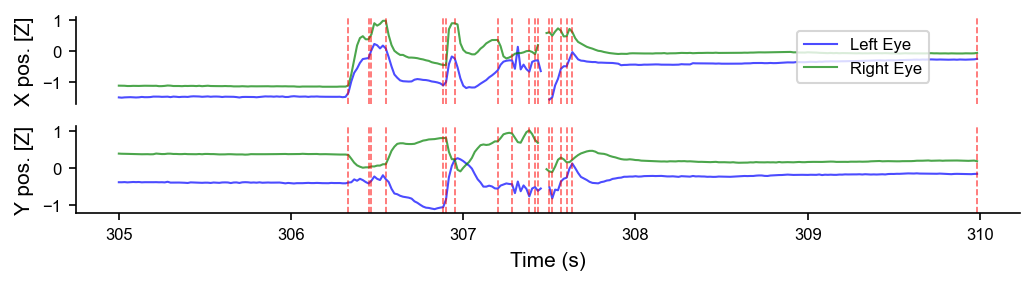

In [22]:
def plot_zoomed_in_w_saccades(start_time, end_time, traces=None, left_df=None, right_df=None, outlier_threshold=3,
                   left_ms=None, right_ms=None, head_movements_ms=None, state_df=None,
                   figure_size=(15, 6), window_size=10000, bin_size=1000, export_path=None):
    """
    Updated function:
    1. Adds vertical lines for saccade events.
    """
    left_df = left_df.reset_index(drop=True)
    right_df = right_df.reset_index(drop=True)

    x_axis = left_df['ms_axis'] / 1000  # Convert ms to seconds

    left_df_z = left_df.apply(lambda x: zscore(x, nan_policy='omit'))
    right_df_z = right_df.apply(lambda x: zscore(x, nan_policy='omit'))

    mask = (x_axis >= start_time) & (x_axis <= end_time)

    def remove_outliers_aligned(trace, threshold):
        trace = np.asarray(trace)
        outlier_mask = np.abs(trace) <= threshold
        return np.where(outlier_mask, trace, np.nan)

    zoomed_x_axis = x_axis[mask]

    # Prepare data for each trace
    left_center_x = remove_outliers_aligned(left_df_z['center_x'], outlier_threshold)[mask]
    right_center_x = remove_outliers_aligned(right_df_z['center_x'], outlier_threshold)[mask]
    left_center_y = remove_outliers_aligned(left_df_z['center_y'], outlier_threshold)[mask]
    right_center_y = remove_outliers_aligned(right_df_z['center_y'], outlier_threshold)[mask]
    left_pupil_diameter = remove_outliers_aligned(left_df_z['pupil_diameter'], outlier_threshold)[mask]
    right_pupil_diameter = remove_outliers_aligned(right_df_z['pupil_diameter'], outlier_threshold)[mask]

    # Combine left and right saccade timestamps
    saccade_times = np.sort(np.unique(np.concatenate((left_ms, right_ms)))) / 1000  # Convert to seconds
    saccade_times = saccade_times[(saccade_times >= start_time) & (saccade_times <= end_time)]  # Filter within window

    # Create plot
    fig, axes = plt.subplots(nrows=len(traces), ncols=1, figsize=figure_size, sharex=True, dpi=150)
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    # Collect handles and labels for a single legend
    legend_handles = []
    legend_labels = []

    # Iterate over traces and plot
    for i, trace in enumerate(traces):
        if trace == 'center_x':
            line_left, = axes[i].plot(zoomed_x_axis, left_center_x, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            line_right, = axes[i].plot(zoomed_x_axis, right_center_x, label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('X pos. [Z]')
        elif trace == 'center_y':
            line_left, = axes[i].plot(zoomed_x_axis, left_center_y, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            line_right, = axes[i].plot(zoomed_x_axis, right_center_y, label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Y pos. [Z]')
        elif trace == 'pupil_diameter':
            line_left, = axes[i].plot(zoomed_x_axis, left_pupil_diameter, label='Left Eye', color='blue', linewidth=1, alpha=0.7)
            line_right, = axes[i].plot(zoomed_x_axis, right_pupil_diameter, label='Right Eye', color='green', linewidth=1, alpha=0.7)
            axes[i].set_ylabel('Diameter')
        elif trace == 'saccade_frequency':
            line_rate, = axes[i].plot(zoomed_x_axis, zoomed_saccade_rate, label='Saccade Rate', color='black', linewidth=1)
            axes[i].set_ylabel('Saccades/Sec.')

        # Add vertical lines for saccades
        for saccade_time in saccade_times:
            axes[i].axvline(x=saccade_time, color='red', linestyle='--', linewidth=0.8, alpha=0.6)

        # Add handles and labels for single legend (only once)
        if i == 0:
            legend_handles.append(line_left)
            legend_handles.append(line_right)
            legend_labels.append('Left Eye')
            legend_labels.append('Right Eye')

        # Hide x-axis completely for all but the last trace
        if i < len(traces) - 1:
            axes[i].spines['bottom'].set_visible(False)
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Final adjustments for each trace
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

    # Shared X-axis label on the last trace
    axes[-1].set_xlabel('Time (s)')

    # Add a single legend
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(0.9, 0.9))

    plt.tight_layout()
    if export_path:
        plt.savefig(export_path, format='pdf')
    plt.show()
plot_zoomed_in_w_saccades(start_time=305, end_time=310, 
               traces=['center_x', 'center_y'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               outlier_threshold=3,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=None,
               figure_size=(7, 2),export_path=export_path)

In [9]:
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\{t}_zoomed_in_quite.pdf'
plot_zoomed_in(start_time=210, end_time=240, 
               traces=['center_x', 'center_y'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               outlier_threshold=2,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=behavior_df,
               figure_size=(2.5, 2),export_path=export_path)

NameError: name 'plot_zoomed_in' is not defined

exporting to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\20241214-1141_zoomed_in_active.pdf


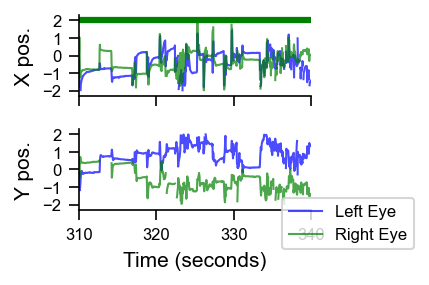

In [31]:
t = datetime.datetime.now().strftime('%Y%m%d-%H%M')
export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\{t}_zoomed_in_active.pdf'
plot_zoomed_in(start_time=310, end_time=340, 
               traces=['center_x', 'center_y'], 
               left_df=block.left_eye_data, right_df=block.right_eye_data,
               outlier_threshold=2,
               left_ms=block.l_saccade_df.saccade_on_ms.values, right_ms=block.r_saccade_df.saccade_on_ms.values,
               head_movements_ms=None, 
               state_df=behavior_df,
               figure_size=(2.5, 2),export_path=export_path)

Frame dtype: uint8, min: 0, max: 255, shape = (480, 640)


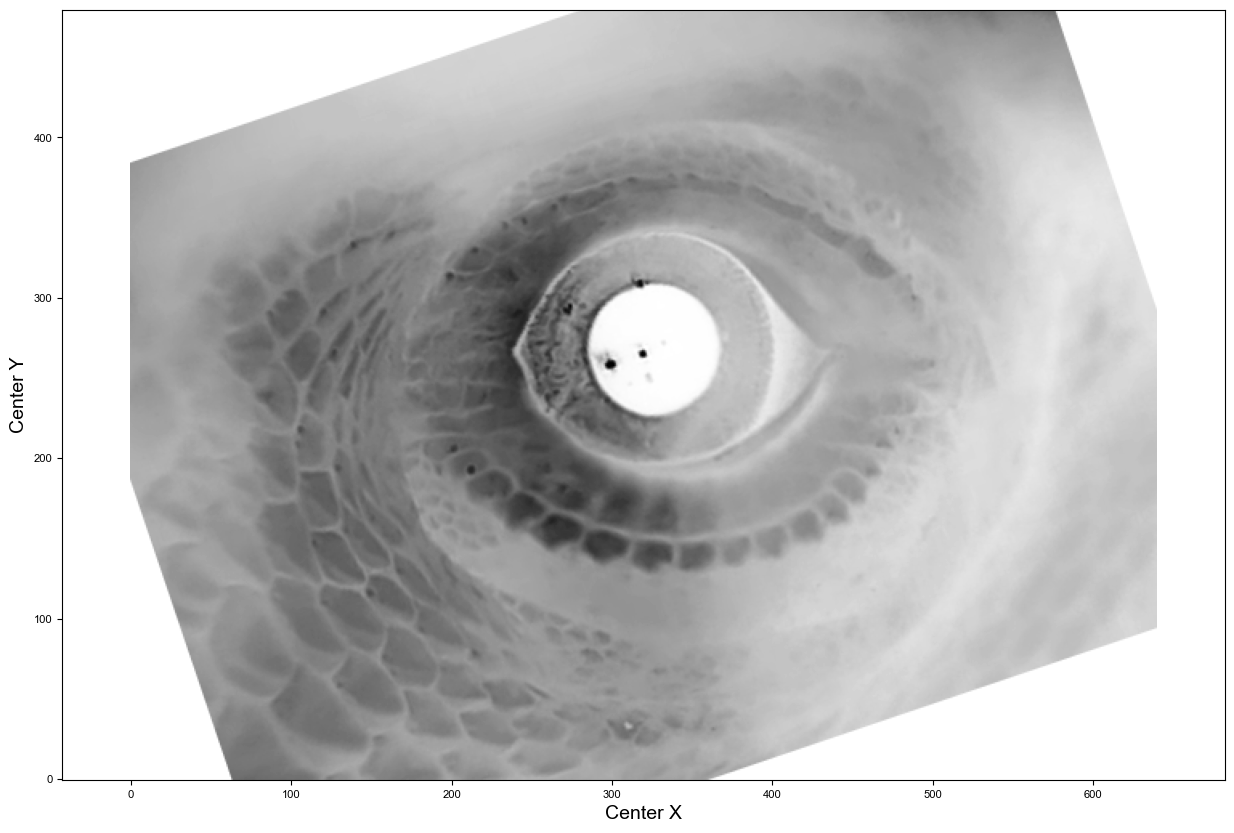

The reference point returned for this video is: X = 354.9872200032116, Y = 273.1118905502584


(354.9872200032116, 273.1118905502584)

In [42]:
def get_best_reference(self, eye):
    if eye == 'left':
        df = self.left_eye_data
    elif eye == 'right':
        df = self.right_eye_data
    else:
        print('Eye not recognized, try left/right')
    s = df.major_ax / df.minor_ax
    anchor_ind = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
    roundest_frame_num = df['eye_frame'].iloc[anchor_ind]
    frame = self.get_rotated_frame(roundest_frame_num, eye,xflip=True)
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(f'Frame dtype: {frame.dtype}, min: {frame.min()}, max: {frame.max()}, shape = {np.shape(frame)}')

    minimal_ratio = df.iloc[anchor_ind].ratio
    reference_x = df.center_x.iloc[anchor_ind]
    reference_y = df.center_y.iloc[anchor_ind]
    # plot with scatter for best reference verification:
    fig, axs = plt.subplots(1, 1, figsize=(15, 10))

    # Scatter plot with points colored by the 'ratio' column
    #sc = axs.scatter(df.center_x, df.center_y, c=df.ratio, cmap='jet', alpha=0.2)
    #axs.scatter(reference_x, reference_y, c='purple', alpha=1, s=40)

    # Add color bar to the plot with enlarged font size
   #cbar = plt.colorbar(sc, ax=axs)
    #cbar.ax.tick_params(labelsize=14)  # Adjust font size of tick labels
    #cbar.set_label('Ratio', fontsize=16)  # Adjust font size of color bar label

    # Adjust font size of axis labels
    axs.set_xlabel('Center X', fontsize=14)
    axs.set_ylabel('Center Y', fontsize=14)
    #axs.vlines(320, 240 - 20, 240 + 20)
    #axs.hlines(240, 320 - 20, 320 + 20)
    axs.axis('equal')
    axs.imshow(frame, origin='lower', cmap='gray_r')
    plt.show()
    print(f'The reference point returned for this video is: X = {reference_x}, Y = {reference_y}')
    return reference_x, reference_y

get_best_reference(block,'left')

Frame dtype: uint8, min: 0, max: 255, shape = (480, 640)


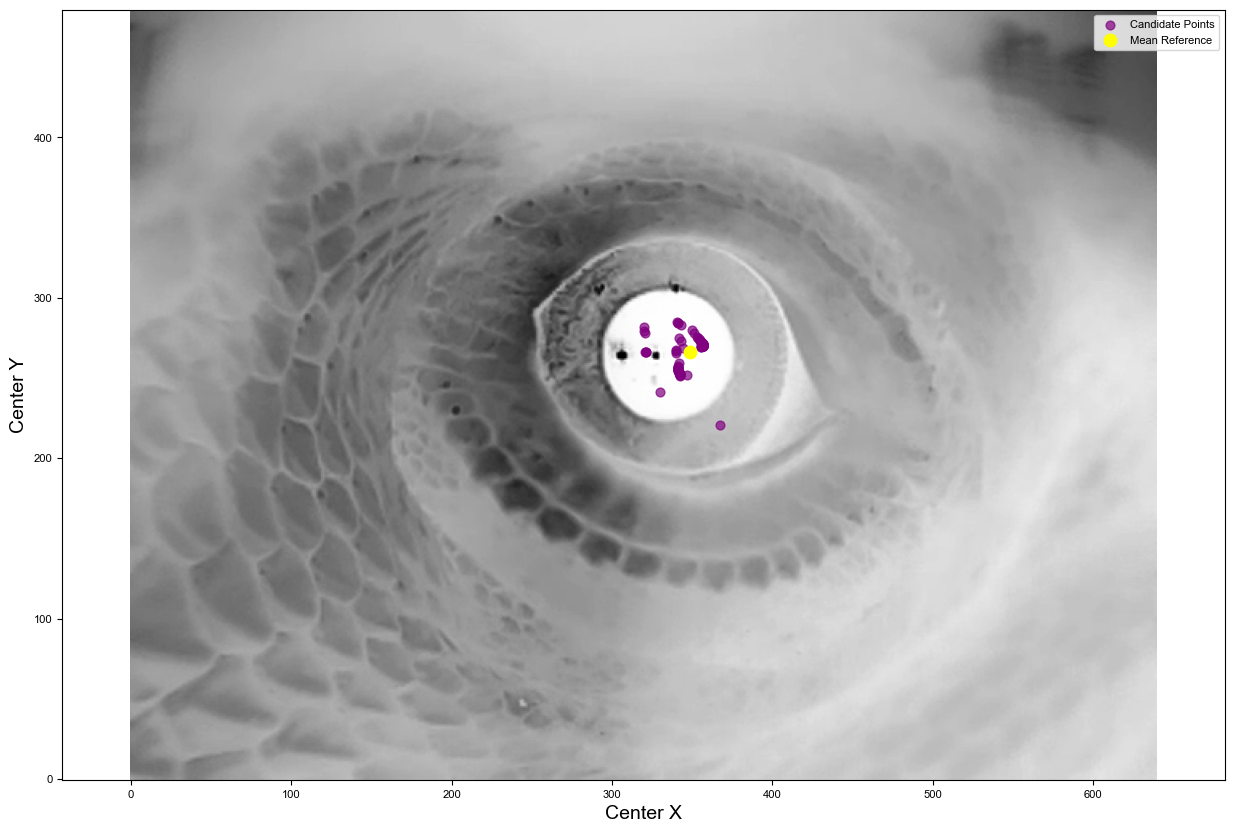

The computed mean reference point for left eye is: X = 348.5804933067627, Y = 266.3788696633765


(348.5804933067627, 266.3788696633765)

In [280]:
def pick_reference_opencv(self, eye):
    """
    Display an image with candidate points overlaid as a continuous gradient (using COLORMAP_TURBO)
    according to their ellipse ratio (major_ax/minor_ax). The background frame is taken from the candidate
    whose ratio is closest to 1. We then use a stratified subset of points to build an RBF interpolator and
    extrapolate the (x,y) coordinate where the ratio is predicted to equal 1 (even if such a point is not 
    directly observed). This extrapolated reference is drawn on the image to help guide your selection.
    A vertical colorbar is appended. Finally, an OpenCV window allows you to click on the main image area 
    (excluding the colorbar) to select your final reference point.
    
    Adjustments:
      1. A colorbar is included on the right.
      2. Candidate points are drawn with an alpha (transparency) of 0.5.
      3. The extrapolated reference point is computed (via RBF regression on a stratified subset) and marked.
    
    :param eye: 'left' or 'right'
    :return: Tuple (ref_x, ref_y) representing the selected reference coordinates, or None if canceled.
    """
    import cv2
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize
    from scipy.interpolate import Rbf

    # --- 1. Select and clean the data ---
    if eye == 'left':
        df = self.left_eye_data.copy()
    elif eye == 'right':
        df = self.right_eye_data.copy()
    else:
        print("Eye not recognized. Choose 'left' or 'right'.")
        return None

    # Drop rows with missing center coordinates.
    df = df.dropna(subset=['center_x', 'center_y'])
    
    # Ensure the 'ratio' column exists (ratio = major_ax / minor_ax).
    if 'ratio' not in df.columns:
        df['ratio'] = df['major_ax'] / df['minor_ax']

    # Determine ratio range (used later for normalization and binning).
    min_ratio = df['ratio'].min()
    max_ratio = df['ratio'].max()

    # --- 2. Extrapolate the best reference point via regression using a stratified subset ---
    # We want to find the (x,y) where the interpolated ratio is closest to 1.
    x_data = df['center_x'].values
    y_data = df['center_y'].values
    ratio_data = df['ratio'].values

    # Stratified sampling: divide the ratio range into bins and sample equally.
    n_bins = 10
    n_per_bin = 50  # maximum points per bin
    subset_indices = []
    bin_edges = np.linspace(min_ratio, max_ratio, n_bins + 1)
    for i in range(n_bins):
        # Select indices of points that fall into the current bin.
        indices = np.where((ratio_data >= bin_edges[i]) & (ratio_data < bin_edges[i+1]))[0]
        if len(indices) > 0:
            n_select = min(n_per_bin, len(indices))
            selected = np.random.choice(indices, n_select, replace=False)
            subset_indices.extend(selected)
    subset_indices = np.array(subset_indices)

    if len(subset_indices) == 0:
        print("No data available for regression.")
        return None

    x_data_subset = x_data[subset_indices]
    y_data_subset = y_data[subset_indices]
    ratio_data_subset = ratio_data[subset_indices]

    # Create an RBF interpolator using the subset.
    rbf = Rbf(x_data_subset, y_data_subset, ratio_data_subset, function='multiquadric', smooth=1)

    # Define the objective function: squared difference between interpolated ratio and 1.
    def objective(p):
        return (rbf(p[0], p[1]) - 1) ** 2

    # Use the candidate with ratio closest to 1 as an initial guess.
    s = abs(df['ratio'] - 1)
    init = np.array([df.loc[s.idxmin(), 'center_x'], df.loc[s.idxmin(), 'center_y']])
    res = minimize(objective, init, method='Nelder-Mead')
    extrapolated_ref = (int(round(res.x[0])), int(round(res.x[1])))

    # --- 3. Select a background frame ---
    # Use the candidate with ratio closest to 1.
    idx = s.idxmin()
    best_frame_num = df.loc[idx, 'eye_frame']
    frame = self.get_frame(best_frame_num, eye, xflip=True)
    if frame is None:
        print("Error retrieving the background frame.")
        return None

    # Convert the frame to grayscale and then back to BGR (so we can draw in color).
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    background = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR)
    
    # --- 4. Overlay candidate points with transparency ---
    overlay = background.copy()

    for _, row in df.iterrows():
        x = int(round(row['center_x']))
        y = int(round(row['center_y']))
        ratio = row['ratio']
        # Normalize the ratio to the range [0, 1].
        norm = (ratio - min_ratio) / (max_ratio - min_ratio) if max_ratio > min_ratio else 0.5
        value = int(norm * 255)
        dummy = np.uint8([[value]])
        color = cv2.applyColorMap(dummy, cv2.COLORMAP_TURBO)[0, 0].tolist()
        # Draw a small filled circle on the overlay.
        cv2.circle(overlay, (x, y), radius=4, color=color, thickness=-1)

    # Blend the overlay with the background using alpha for transparency.
    alpha = 0.5
    blended = cv2.addWeighted(overlay, alpha, background, 1 - alpha, 0)

    # --- 5. Mark the extrapolated best reference point ---
    cv2.drawMarker(blended, extrapolated_ref, color=(0, 0, 255),
                   markerType=cv2.MARKER_TILTED_CROSS, markerSize=30, thickness=3)
    cv2.putText(blended, "Extrapolated Best Ref", (extrapolated_ref[0] + 10, extrapolated_ref[1] + 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # --- 6. Create a vertical colorbar ---
    bar_width = 50
    bar_height = blended.shape[0]
    gradient = np.linspace(0, 255, bar_height, dtype=np.uint8).reshape(bar_height, 1)
    gradient = np.repeat(gradient, bar_width, axis=1)
    colorbar = cv2.applyColorMap(gradient, cv2.COLORMAP_TURBO)
    cv2.putText(colorbar, f"{min_ratio:.2f}", (5, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(colorbar, f"{max_ratio:.2f}", (5, bar_height - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # --- 7. Combine the blended image and the colorbar ---
    combined = np.hstack([blended, colorbar])
    cv2.putText(combined, "Click on main image to select ref (ESC to cancel)",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # --- 8. Interactive selection via OpenCV window ---
    ref_point = []  # This will store the selected [x, y] coordinate.
    window_name = "Select Reference"
    cv2.namedWindow(window_name)

    def mouse_callback(event, x, y, flags, param):
        nonlocal ref_point, combined
        # Only record clicks in the main image area (exclude the colorbar).
        if event == cv2.EVENT_LBUTTONDOWN and x < blended.shape[1]:
            ref_point = [x, y]
            # Mark the selected point with a bright star marker.
            cv2.drawMarker(combined, (x, y), color=(0, 255, 255),
                           markerType=cv2.MARKER_STAR, markerSize=30, thickness=3)
            cv2.imshow(window_name, combined)

    cv2.setMouseCallback(window_name, mouse_callback)
    cv2.imshow(window_name, combined)
    while True:
        key = cv2.waitKey(1) & 0xFF
        if ref_point:
            break
        if key == 27:  # ESC key to cancel.
            break
    cv2.destroyAllWindows()

    if ref_point:
        print("Selected reference point: X = {}, Y = {}".format(ref_point[0], ref_point[1]))
        return ref_point[0], ref_point[1]
    else:
        print("No reference point selected.")
        return None

get_best_reference(block,'left')

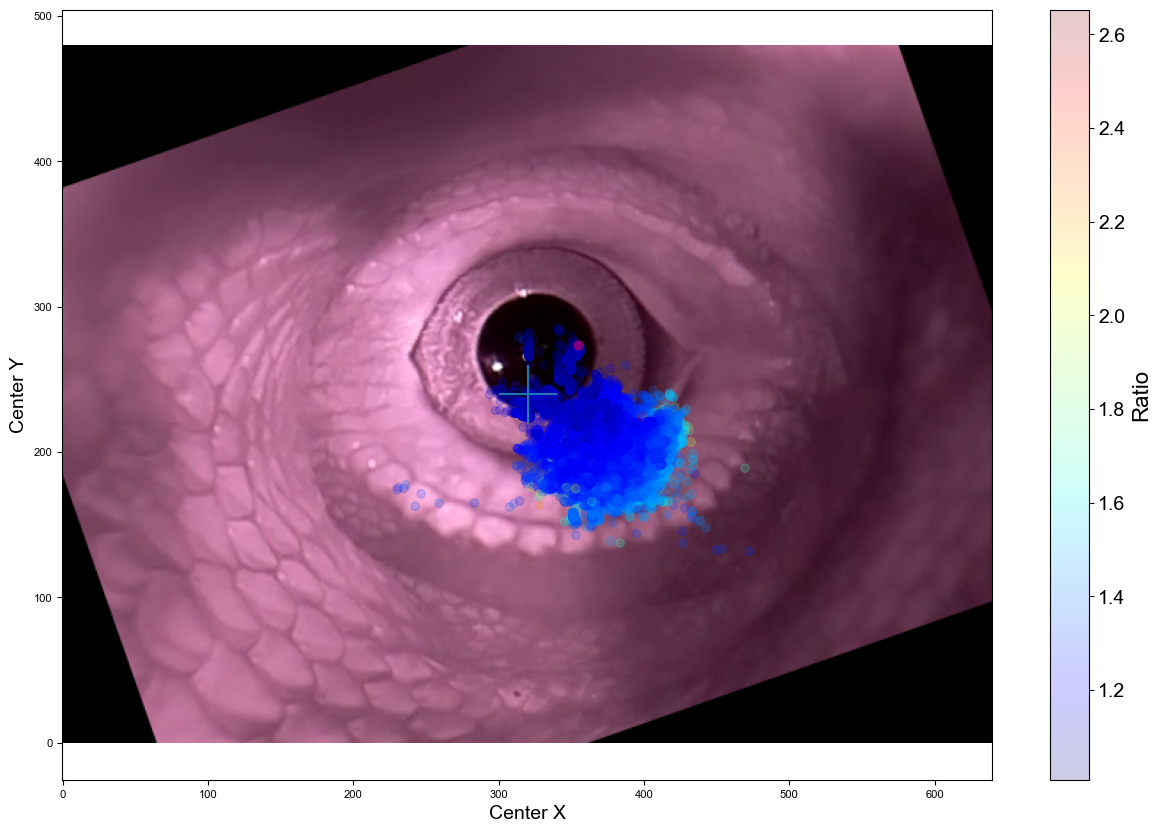

The reference point returned for this video is: X = 354.6195131424376, Y = 273.4961515572463


(354.6195131424376, 273.4961515572463)

In [287]:
    def get_best_reference(self, eye):
        if eye == 'left':
            df = self.left_eye_data
        elif eye == 'right':
            df = self.right_eye_data
        else:
            print('Eye not recognized, try left/right')
        s = df.major_ax / df.minor_ax
        anchor_ind = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
        roundest_frame_num = df['eye_frame'].iloc[anchor_ind]
        frame = self.get_rotated_frame(roundest_frame_num, eye)
        minimal_ratio = df.iloc[anchor_ind].ratio
        reference_x = df.center_x.iloc[anchor_ind]
        reference_y = df.center_y.iloc[anchor_ind]
        # plot with scatter for best reference verification:
        fig, axs = plt.subplots(1, 1, figsize=(15, 10))

        # Scatter plot with points colored by the 'ratio' column
        sc = axs.scatter(df.center_x, df.center_y, c=df.ratio, cmap='jet', alpha=0.2)
        axs.scatter(reference_x, reference_y, c='purple', alpha=1, s=40)

        # Add color bar to the plot with enlarged font size
        cbar = plt.colorbar(sc, ax=axs)
        cbar.ax.tick_params(labelsize=14)  # Adjust font size of tick labels
        cbar.set_label('Ratio', fontsize=16)  # Adjust font size of color bar label

        # Adjust font size of axis labels
        axs.set_xlabel('Center X', fontsize=14)
        axs.set_ylabel('Center Y', fontsize=14)
        axs.vlines(320, 240 - 20, 240 + 20)
        axs.hlines(240, 320 - 20, 320 + 20)
        axs.axis('equal')
        axs.imshow(frame, origin='lower', cmap='gray')
        plt.show()
        print(f'The reference point returned for this video is: X = {reference_x}, Y = {reference_y}')
        return reference_x, reference_y

In [286]:
def pick_reference_opencv(self, eye):
    """
    Display an image with candidate points overlaid as a continuous gradient (using COLORMAP_TURBO)
    according to their ellipse ratio (major_ax/minor_ax) from the rotated eye data. The background frame is 
    taken from the candidate whose ratio is closest to 1, using the rotated frame via get_rotated_frame.
    
    We then use a stratified subset of points and RBF interpolation to extrapolate the (x,y) coordinate where 
    the ratio is predicted to equal 1 (even if such a point is not directly observed). This extrapolated reference 
    is drawn on the image to help guide your selection.
    
    A vertical colorbar is appended to the right. Finally, an OpenCV window allows you to click on the main image 
    area (excluding the colorbar) to select your final reference point. The function returns the selected (x, y) 
    coordinates.
    
    Adjustments:
      - Uses get_rotated_frame (rotation correction) to display the tilted image.
      - Candidate points are overlaid with a semi-transparent (alpha=0.5) color gradient.
      - Extrapolated “best reference” is computed via RBF interpolation on a stratified subset of the data.
      - A vertical colorbar (using COLORMAP_TURBO) is shown.
    
    :param eye: 'left' or 'right'
    :return: Tuple (ref_x, ref_y) representing the selected reference coordinates, or None if canceled.
    """
    import cv2
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize
    from scipy.interpolate import Rbf

    # --- 1. Select and clean the data ---
    if eye == 'left':
        df = self.left_eye_data.copy()
    elif eye == 'right':
        df = self.right_eye_data.copy()
    else:
        print("Eye not recognized. Choose 'left' or 'right'.")
        return None

    # Drop rows with missing center coordinates.
    df = df.dropna(subset=['center_x', 'center_y'])
    
    # Ensure the 'ratio' column exists (ratio = major_ax / minor_ax).
    if 'ratio' not in df.columns:
        df['ratio'] = df['major_ax'] / df['minor_ax']
    
    # Determine ratio range (for normalization and stratification).
    min_ratio = df['ratio'].min()
    max_ratio = df['ratio'].max()
    
    # --- 2. Extrapolate the ideal reference point via RBF regression on a stratified subset ---
    x_data = df['center_x'].values
    y_data = df['center_y'].values
    ratio_data = df['ratio'].values

    # Stratified sampling: split the ratio range into bins and sample up to n_per_bin points from each.
    n_bins = 10
    n_per_bin = 50  # maximum points per bin (adjust as needed)
    subset_indices = []
    bin_edges = np.linspace(min_ratio, max_ratio, n_bins + 1)
    for i in range(n_bins):
        indices = np.where((ratio_data >= bin_edges[i]) & (ratio_data < bin_edges[i+1]))[0]
        if len(indices) > 0:
            n_select = min(n_per_bin, len(indices))
            selected = np.random.choice(indices, n_select, replace=False)
            subset_indices.extend(selected)
    subset_indices = np.array(subset_indices)
    
    if len(subset_indices) == 0:
        print("No data available for regression.")
        return None

    # Build the subset.
    x_subset = x_data[subset_indices]
    y_subset = y_data[subset_indices]
    ratio_subset = ratio_data[subset_indices]
    
    # Create the RBF interpolator.
    rbf = Rbf(x_subset, y_subset, ratio_subset, function='multiquadric', smooth=1)
    
    # Define an objective function: squared difference from 1.
    def objective(p):
        return (rbf(p[0], p[1]) - 1) ** 2
    
    # Use the candidate with ratio closest to 1 as an initial guess.
    idx_closest = np.argmin(np.abs(ratio_data - 1))
    init_guess = np.array([x_data[idx_closest], y_data[idx_closest]])
    
    res = minimize(objective, init_guess, method='Nelder-Mead')
    extrapolated_ref = (int(round(res.x[0])), int(round(res.x[1])))
    
    # --- 3. Select a background frame using rotation correction ---
    # Use the candidate with ratio closest to 1.
    best_frame_num = df.loc[idx_closest, 'eye_frame']
    frame = self.get_rotated_frame(best_frame_num, eye)
    if frame is None:
        print("Error retrieving the background frame.")
        return None

    # Convert the rotated frame to grayscale then to BGR (so we can draw in color).
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    background = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR)
    
    # --- 4. Overlay candidate points with transparency ---
    overlay = background.copy()
    for _, row in df.iterrows():
        x = int(round(row['center_x']))
        y = int(round(row['center_y']))
        ratio = row['ratio']
        # Normalize the ratio to [0, 1]
        norm = (ratio - min_ratio) / (max_ratio - min_ratio) if max_ratio > min_ratio else 0.5
        value = int(norm * 255)
        dummy = np.uint8([[value]])
        color = cv2.applyColorMap(dummy, cv2.COLORMAP_TURBO)[0, 0].tolist()
        cv2.circle(overlay, (x, y), radius=4, color=color, thickness=-1)
    
    alpha = 0.5  # transparency for candidate points
    blended = cv2.addWeighted(overlay, alpha, background, 1 - alpha, 0)
    
    # --- 5. Mark the extrapolated best reference point on the blended image ---
    cv2.drawMarker(blended, extrapolated_ref, color=(0, 0, 255),
                   markerType=cv2.MARKER_TILTED_CROSS, markerSize=30, thickness=3)
    cv2.putText(blended, "Extrapolated Best Ref", (extrapolated_ref[0] + 10, extrapolated_ref[1] + 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # --- 6. Create a vertical colorbar ---
    bar_width = 50
    bar_height = blended.shape[0]
    gradient = np.linspace(0, 255, bar_height, dtype=np.uint8).reshape(bar_height, 1)
    gradient = np.repeat(gradient, bar_width, axis=1)
    colorbar = cv2.applyColorMap(gradient, cv2.COLORMAP_TURBO)
    cv2.putText(colorbar, f"{min_ratio:.2f}", (5, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(colorbar, f"{max_ratio:.2f}", (5, bar_height - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # --- 7. Combine the blended image and the colorbar ---
    combined = np.hstack([blended, colorbar])
    cv2.putText(combined, "Click on main image to select ref (ESC to cancel)",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # --- 8. Interactive selection via OpenCV window ---
    ref_point = []  # Will store the selected [x, y] coordinate.
    window_name = "Select Reference"
    cv2.namedWindow(window_name)
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal ref_point, combined
        # Only record clicks in the main image area (exclude the colorbar).
        if event == cv2.EVENT_LBUTTONDOWN and x < blended.shape[1]:
            ref_point = [x, y]
            # Mark the selected point with a bright star marker.
            cv2.drawMarker(combined, (x, y), color=(0, 255, 255),
                           markerType=cv2.MARKER_STAR, markerSize=30, thickness=3)
            cv2.imshow(window_name, combined)
    
    cv2.setMouseCallback(window_name, mouse_callback)
    cv2.imshow(window_name, combined)
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        if ref_point:
            break
        if key == 27:  # ESC key to cancel.
            break
    cv2.destroyAllWindows()
    
    if ref_point:
        print("Selected reference point: X = {}, Y = {}".format(ref_point[0], ref_point[1]))
        return ref_point[0], ref_point[1]
    else:
        print("No reference point selected.")
        return None

pick_reference_opencv(block,'left')

Selected reference point: X = 318, Y = 227


(318, 227)

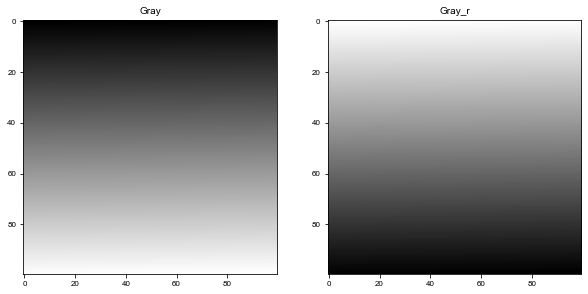

In [132]:
import numpy as np
import matplotlib.pyplot as plt

test_frame = np.linspace(0, 255, 10000, dtype=np.uint8).reshape((100, 100))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(test_frame, cmap='gray')
axs[0].set_title("Gray")

axs[1].imshow(test_frame, cmap='gray_r')
axs[1].set_title("Gray_r")

plt.show()

In [160]:
for block in block_collection:
    block.calibrate_pixel_size(10)

got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder
got the calibration values from the analysis folder


In [161]:
# camera jitter report:
stop_indices_l = []
stop_indices_r = []
for block in tqdm.tqdm(block_collection):
    block.get_jitter_reports(export=False,overwrite=False,remove_led_blinks=False)
    rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
    ldf = pd.DataFrame.from_dict(block.le_jitter_dict)
    bokeh_plotter([rdf.top_correlation_dist], label_list=['drift_distance'])
    stop_ind_r = input('ind to stop?')
    bokeh_plotter([ldf.top_correlation_dist], label_list=['drift_distance'])
    stop_ind_l = input('ind to stop?')
    stop_indices_l.append(stop_ind_l)
    stop_indices_r.append(stop_ind_r)
    

  0%|          | 0/9 [00:00<?, ?it/s]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 11%|█         | 1/9 [01:39<13:12, 99.03s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 22%|██▏       | 2/9 [02:21<07:40, 65.80s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 33%|███▎      | 3/9 [03:23<06:23, 63.97s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 44%|████▍     | 4/9 [04:20<05:05, 61.12s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 56%|█████▌    | 5/9 [04:40<03:05, 46.39s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 67%|██████▋   | 6/9 [05:04<01:56, 38.74s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 78%|███████▊  | 7/9 [06:19<01:41, 50.75s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


 89%|████████▉ | 8/9 [07:03<00:48, 48.62s/it]

jitter report loaded from analysis folder
Got the jitter report - check out re/le_jitter_dict attributes


100%|██████████| 9/9 [07:37<00:00, 50.85s/it]


In [162]:
stop_arr_l = np.array(stop_indices_l).astype(int)
stop_arr_r = np.array(stop_indices_r).astype(int)

distances_collection = []
for i, block in enumerate(block_collection):
    # define jitter dicts
    jitter_dict_l = block.le_jitter_dict
    jitter_dict_r = block.re_jitter_dict
    
    # compute euclidean jitter magnitude
    xl = np.array(jitter_dict_l['x_displacement'])
    yl = np.array(jitter_dict_l['y_displacement'])
    l_distances = (np.sqrt(xl**2+yl**2)*block.L_pix_size*1000)[:stop_arr_l[i]]
    
    
    # compute euclidean jitter magnitude
    xr = np.array(jitter_dict_r['x_displacement'])
    yr = np.array(jitter_dict_r['y_displacement'])
    r_distances = (np.sqrt(xr**2+yr**2)*block.R_pix_size*1000)[:stop_arr_r[i]]
    
    distances_collection.append(np.concatenate([l_distances, r_distances]))

distances = np.concatenate(distances_collection)

Bins: [  0.          35.71428571  71.42857143 107.14285714 142.85714286
 178.57142857 214.28571429 250.         285.71428571 321.42857143
 357.14285714 392.85714286 428.57142857 464.28571429 500.        ]


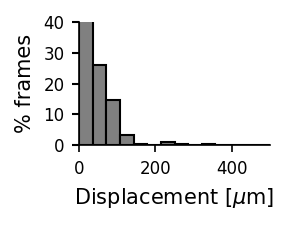

In [185]:

plt.style.use('default')
rc('pdf', fonttype=42)
# Create cumulative distribution plot
#sns.set(style="whitegrid")
fig, axs = plt.subplots(1, figsize=(2, 1.6), dpi=150)

# Plot the histogram
hist, bins = np.histogram(distances, bins=np.linspace(0, 500, 15))
percentage = (hist / len(distances)) * 100

# Use 'gray' for bin fill and 'black' for edges
axs.bar(bins[:-1], percentage, width=np.diff(bins), color='gray', edgecolor='black', align='edge')

# Print bins for debugging
print(f"Bins: {bins}")

# Set title and labels for the histogram
#title = f'Image Displacement'
#axs.set_title(title, fontsize=10)
axs.set_xlabel('Displacement [$\mu$m]', fontsize=10)
axs.set_ylabel('% frames', fontsize=10)

# Adjust tick label sizes
axs.tick_params(axis='both', which='major', labelsize=8)
axs.tick_params(axis='y', which='both', length=3, color='black')  
axs.set_yticks([0,10,20,30,40])
axs.tick_params(axis='y', which='major', length=3, width=1, color='black')
# Set white background and black text
axs.set_facecolor('white')
axs.title.set_color('black')
axs.xaxis.label.set_color('black')
axs.yaxis.label.set_color('black')
axs.tick_params(colors='black')
axs.grid(False)
axs.spines['top'].set_visible(False)  # Remove the top spine
axs.spines['right'].set_visible(False)  # Remove the right spine
axs.spines['left'].set_color('black')
axs.spines['bottom'].set_color('black')
axs.tick_params(axis='y', which='both', length=3.5, color='black')  
axs.tick_params(axis='x', which='both', length=3.5)
# Set x-axis and y-axis limits
axs.set_xlim(0, 500)
axs.set_ylim(0, 40)
plt.tight_layout()

# Save and show the figure
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#export_path = fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\{t}_jitter_report.pdf'
plt.savefig(export_path, format='pdf')
plt.show()


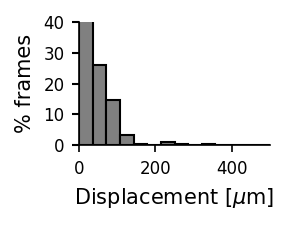

In [196]:
# export the dataset required for this plot:

# Create export directory
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_dir = pathlib.Path(fr'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking') / f"{t}_jitter_histogram_with_data"
export_dir.mkdir(parents=True, exist_ok=True)
# Save distances as a pickle file
distances_file = export_dir / "distances.pkl"
with open(distances_file, "wb") as f:
    pickle.dump(distances, f)

plt.style.use('default')
rc('pdf', fonttype=42)
# Create cumulative distribution plot
#sns.set(style="whitegrid")
fig, axs = plt.subplots(1, figsize=(2, 1.6), dpi=150)

# Plot the histogram
hist, bins = np.histogram(distances, bins=np.linspace(0, 500, 15))
percentage = (hist / len(distances)) * 100

# Use 'gray' for bin fill and 'black' for edges
axs.bar(bins[:-1], percentage, width=np.diff(bins), color='gray', edgecolor='black', align='edge')

# Print bins for debugging
# print(f"Bins: {bins}")

# Set title and labels for the histogram
#title = f'Image Displacement'
#axs.set_title(title, fontsize=10)
axs.set_xlabel('Displacement [$\mu$m]', fontsize=10)
axs.set_ylabel('% frames', fontsize=10)

# Adjust tick label sizes
axs.tick_params(axis='both', which='major', labelsize=8)
axs.tick_params(axis='y', which='both', length=3, color='black')  
axs.set_yticks([0,10,20,30,40])
axs.tick_params(axis='y', which='major', length=3, width=1, color='black')
# Set white background and black text
axs.set_facecolor('white')
axs.title.set_color('black')
axs.xaxis.label.set_color('black')
axs.yaxis.label.set_color('black')
axs.tick_params(colors='black')
axs.grid(False)
axs.spines['top'].set_visible(False)  # Remove the top spine
axs.spines['right'].set_visible(False)  # Remove the right spine
axs.spines['left'].set_color('black')
axs.spines['bottom'].set_color('black')
axs.tick_params(axis='y', which='both', length=3.5, color='black')  
axs.tick_params(axis='x', which='both', length=3.5)
# Set x-axis and y-axis limits
axs.set_xlim(0, 500)
axs.set_ylim(0, 40)
plt.savefig(export_dir / f'{t} jitter_hist.pdf', format='pdf')
plt.tight_layout()